## Cointegracion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.simplefilter("ignore")

In [2]:
dta = pd.read_excel("./data/PeruData.xlsx", sheet_name="Trimestral", skiprows=1)
dta = dta[[
    'Trimestres', 'Producto bruto interno por tipo de gasto (millones S/ 2007) - PBI',
    'Producto bruto interno por tipo de gasto (millones S/ 2007) - Demanda Interna - Consumo Privado',
    'Producto bruto interno (millones de soles constantes de 2007) - Comercio',
    'Producto bruto interno (millones de soles constantes de 2007) - Servicios',
    'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)',
    'Liquidez de las sociedades creadoras de depósito (fin de periodo) - Circulante (millones S/)'
    ]]

dta.rename({
    'Producto bruto interno por tipo de gasto (millones S/ 2007) - PBI': 'PBI',
    'Producto bruto interno por tipo de gasto (millones S/ 2007) - Demanda Interna - Consumo Privado': 'Consumo_privado',
    'Producto bruto interno (millones de soles constantes de 2007) - Comercio': 'Comercio',
    'Producto bruto interno (millones de soles constantes de 2007) - Servicios': 'Servicio',
    'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)': 'IPC',
    'Liquidez de las sociedades creadoras de depósito (fin de periodo) - Circulante (millones S/)': 'Circulante'
    }, axis=1, inplace=True)

dta.index = pd.period_range("1980Q1", "2022Q2", freq="Q")

dta.to_excel("./data/data_coint.xlsx", index=True)
dta = pd.read_excel("./data/data_coint.xlsx", index_col="Unnamed: 0").drop("Trimestres", axis=1)
dta = dta.dropna()

In [3]:
# Creacion de indices 2021=100
dta["PBI"] = (dta["PBI"]/ dta["PBI"][dta["PBI"].index.get_level_values(0) == '2021'].mean() )*100
dta["Consumo_privado"] = (dta["Consumo_privado"]/ dta["Consumo_privado"][dta["Consumo_privado"].index.get_level_values(0) == '2021'].mean() )*100
dta["Comercio"] = (dta["Comercio"]/ dta["Comercio"][dta["Comercio"].index.get_level_values(0) == '2021'].mean() )*100
dta["Servicio"] = (dta["Servicio"]/ dta["Servicio"][dta["Servicio"].index.get_level_values(0) == '2021'].mean() )*100
dta["IPC"] = (dta["IPC"]/ dta["IPC"][dta["IPC"].index.get_level_values(0) == '2021'].mean() )*100
dta["Circulante"] = (dta["Circulante"]/ dta["Circulante"][dta["Circulante"].index.get_level_values(0) == '2021'].mean() )*100

#### Test de cointegracion
Se puede testear la presencia de cointegracion entre variables. De manera preliminar, se puede esperar que las siguientes relaciones de cointegracion:
* PBI y Consumo privado
* PBI comercio y PBI servicio
* IPC y Circulante

Para poder tener una relacion de cointegracion es necesario que ambas series sean raiz unitarias y estacionarias en sus primeras diferencias. Luego, la combinacion lineal (e.g. el residuo de un modelo con ambas) debe ser estacionaria.

Primero se hara test de raiz unitaria a todas las series:

In [4]:
for names in dta.columns:
    adf = adfuller(dta[names], maxlag=3)

    print(f"El t-estadistico de {names}:")
    print(adf[0])
    print("Los valores criticos")
    print(adf[4])
    print("")

El t-estadistico de PBI:
0.27048731409293203
Los valores criticos
{'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}

El t-estadistico de Consumo_privado:
0.4341986357228103
Los valores criticos
{'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}

El t-estadistico de Comercio:
-0.14339178270987957
Los valores criticos
{'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}

El t-estadistico de Servicio:
0.9437637371935055
Los valores criticos
{'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}

El t-estadistico de IPC:
-0.5367260500482721
Los valores criticos
{'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}

El t-estadistico de Circulante:
3.217360752858519
Los valores criticos
{'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}



En ninguno de los casos se pueede rechazar que exista raiz unitaria en las series. Ahora, se analizara el test de raiz unitaria de los errores entre las variables que posiblemente cuenten con cointegracion

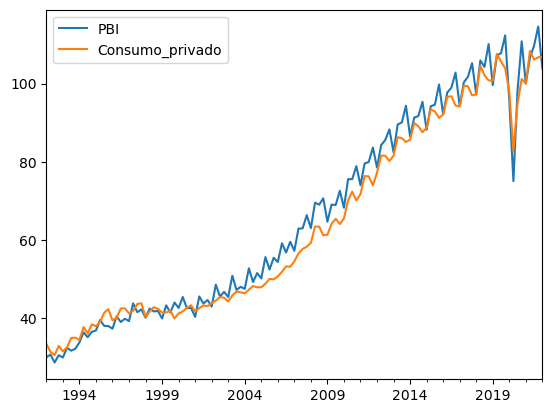

In [5]:
dta[["PBI", "Consumo_privado"]].plot()

plt.show()

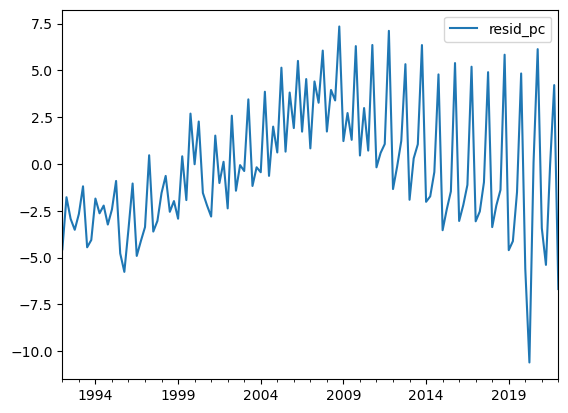

In [6]:
model = sm.OLS(dta["PBI"], dta["Consumo_privado"]).fit()
dta["resid_pc"] = dta["PBI"] - dta["Consumo_privado"]*model.params[0]

dta[["resid_pc"]].plot()
plt.show()

Se rechaza raiz unitaria en los residuos entre el PBI y el consumo privado con 1% de significancia, por lo tanto hay cointegracion

In [7]:
adf = adfuller(dta["resid_pc"], maxlag=1)
print(adf[0])
print("")
print(adf[4])

-8.636981591917353

{'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}


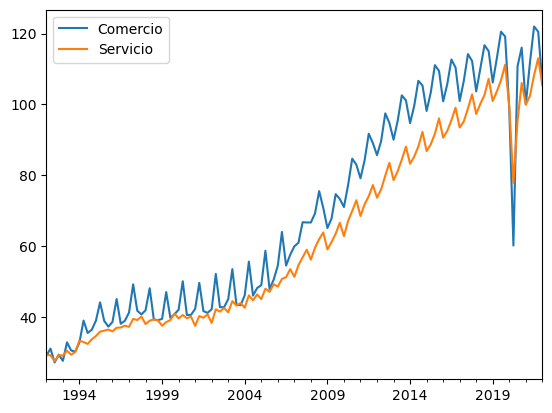

In [8]:
dta[["Comercio", "Servicio"]].plot()

plt.show()

Para el caso del PBI comercio y servicio si hay cointegracion

In [9]:
model = sm.OLS(dta["Comercio"], dta["Servicio"]).fit()
dta["resid_cs"] = dta["Comercio"] - dta["Servicio"]*model.params[0]

adf = adfuller(dta["resid_cs"], maxlag=1)
print(adf[0])
print("")
print(adf[4])

-7.571468226001188

{'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}


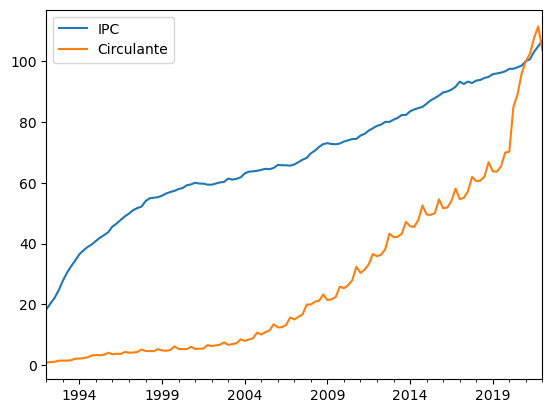

In [10]:
dta[["IPC", "Circulante"]].plot()

plt.show()

Finalmente, para el caso del IPC y circulante no parece haber cointegracion

In [11]:
model = sm.OLS(dta["IPC"], dta["Circulante"]).fit()
dta["resid_ic"] = dta["IPC"] - dta["Circulante"]*model.params[0]

adf = adfuller(dta["resid_ic"], maxlag=1)
print(adf[0])
print("")
print(adf[4])

1.9988521349550137

{'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}


### Estimacion por ECM
Con la presencia de cointegracion entre PBI y el consumo privado, se puede estimar el siguiente modelo:

In [12]:
y = dta["PBI"]; X = dta[["Consumo_privado"]]

model_pc = tsa.UECM(y, None, X, 1).fit()
print(model_pc.summary())

                              UECM Model Results                              
Dep. Variable:                  D.PBI   No. Observations:                  121
Model:                     UECM(0, 1)   Log Likelihood                -316.414
Method:               Conditional MLE   S.D. of innovations             70.179
Date:                Sun, 25 Dec 2022   AIC                            642.827
Time:                        17:46:55   BIC                            656.806
Sample:                    04-01-1992   HQIC                           648.504
                         - 01-01-2022                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5710      0.875     -0.652      0.515      -2.304       1.162
PBI.L1                  -0.7888      0.092     -8.567      0.000      -0.971      -0.606
Consumo_priv

#### Referencias:
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.ardl.UECM.html#statsmodels.tsa.ardl.UECM